## Setting Up the Environment

In [1]:
import tensorflow as tf
from __future__ import absolute_import, division, print_function, unicode_literals
print("Keras Version: ", tf.keras.__version__)

Keras Version:  2.10.0


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
train_dir = 'data/fruits-360_dataset/fruits-360/Training'

In [4]:
test_dir = 'data/fruits-360_dataset/fruits-360/Test'

# load these images off disk using image_dataset_from_directory
https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory
Old solution: Use ImageDataGenerator to rescale the images: https://keras.io/preprocessing/image/

In [5]:
base_dir = '/'
print(base_dir)

/


In [6]:
batch_size = 32
img_height = 128 #180
img_width = 128 #180

In [7]:
# Establishes a Pipe line instead of loading the dataset directly
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 67692 files belonging to 131 classes.
Using 54154 files for training.


In [8]:
class_names = train_ds.class_names
print(class_names)

['Apple Braeburn', 'Apple Crimson Snow', 'Apple Golden 1', 'Apple Golden 2', 'Apple Golden 3', 'Apple Granny Smith', 'Apple Pink Lady', 'Apple Red 1', 'Apple Red 2', 'Apple Red 3', 'Apple Red Delicious', 'Apple Red Yellow 1', 'Apple Red Yellow 2', 'Apricot', 'Avocado', 'Avocado ripe', 'Banana', 'Banana Lady Finger', 'Banana Red', 'Beetroot', 'Blueberry', 'Cactus fruit', 'Cantaloupe 1', 'Cantaloupe 2', 'Carambula', 'Cauliflower', 'Cherry 1', 'Cherry 2', 'Cherry Rainier', 'Cherry Wax Black', 'Cherry Wax Red', 'Cherry Wax Yellow', 'Chestnut', 'Clementine', 'Cocos', 'Corn', 'Corn Husk', 'Cucumber Ripe', 'Cucumber Ripe 2', 'Dates', 'Eggplant', 'Fig', 'Ginger Root', 'Granadilla', 'Grape Blue', 'Grape Pink', 'Grape White', 'Grape White 2', 'Grape White 3', 'Grape White 4', 'Grapefruit Pink', 'Grapefruit White', 'Guava', 'Hazelnut', 'Huckleberry', 'Kaki', 'Kiwi', 'Kohlrabi', 'Kumquats', 'Lemon', 'Lemon Meyer', 'Limes', 'Lychee', 'Mandarine', 'Mango', 'Mango Red', 'Mangostan', 'Maracuja', 'Melo

In [9]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 67692 files belonging to 131 classes.
Using 13538 files for validation.


2022-12-04 10:12:00.766356: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


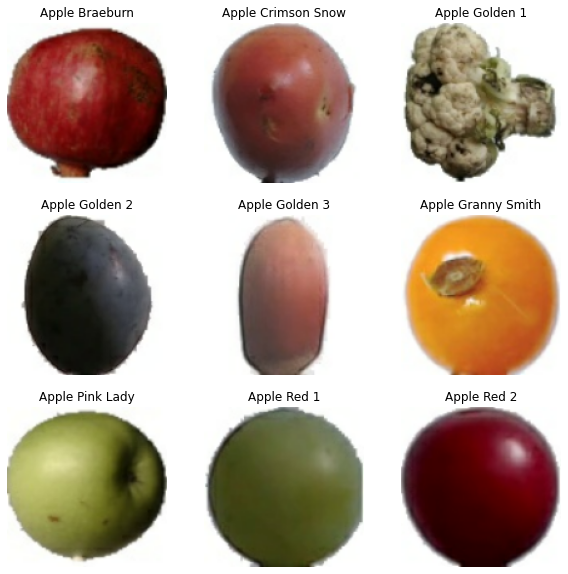

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, groundlabels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[i])
    plt.axis("off")

In [11]:
#manually iterate over the dataset and retrieve batches of images:
#This is a batch of 32 images of shape 180x180x3 (the last dimension referes to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 128, 128, 3)
(32,)


In [12]:
# number of batches
train_ds.cardinality().numpy()

1693

In [13]:
batch_size = 32
img_height = 128
img_width = 128
IMG_SIZE = (img_height, img_width)
IMG_SHAPE = IMG_SIZE + (3,)
num_classes = 131

In [14]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
def getModel(base_model,preprocess_input):
    batch_size = 32
    img_height = 128
    img_width = 128
    IMG_SIZE = (img_height, img_width)
    IMG_SHAPE = IMG_SIZE + (3,)
    num_classes = 131
    
    data_augmentation = tf.keras.Sequential([
      tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
      tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    ])
    

    base_model.trainable = False
    
    header = tf.keras.Sequential([
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(num_classes, activation='softmax', dtype=tf.float32) 
    ])
    
    inputs = tf.keras.Input(shape=IMG_SHAPE)
    x = data_augmentation(inputs)
    x = preprocess_input(x)
    x = base_model(x, training=False)
    outputs = header(x)
    model = tf.keras.Model(inputs, outputs)
    base_learning_rate = 0.0001
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              #loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    return model

In [16]:
def getFineTuneModel(model,fine_tune_at):
  model_base=model.layers[4]
  for layer in model.layers[4].layers[fine_tune_at:]:
    layer.trainable =  True
  base_learning_rate = 0.0001
  model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate/10),
          #loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
          loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
          metrics=['accuracy'])
  return model

In [17]:
def plot_history(history, metric, val_metric):
  acc = history.history[metric]
  val_acc = history.history[val_metric]

  loss=history.history['loss']
  val_loss=history.history['val_loss']

  epochs_range = range(len(acc))

  fig=plt.figure(figsize=(12, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.ylim([min(plt.ylim()),1])
  plt.grid(True)
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.grid(True)
  plt.title('Training and Validation Loss')
  plt.show()
  fig.savefig('traininghistory.pdf')

In [18]:
def plotHistoryFinetune(history,history_finetune,initial_epochs):
  acc = history.history['accuracy']
  acc += history_finetune.history['accuracy']

  val_acc = history.history['val_accuracy']
  val_acc += history_finetune.history['val_accuracy']

  loss = history.history['loss']
  loss += history_finetune.history['loss']

  val_loss = history.history['val_loss']
  val_loss += history_finetune.history['val_loss']

  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.ylim([0.8, 1])
  plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 1, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.ylim([0, 1.0])
  plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.show()


In [19]:
def trainTLModel(base_model,preprocess_input,fine_tune_at,train_ds,val_ds):
  model = getModel(base_model,preprocess_input)
  newModel = model
  fineTuneModel = getFineTuneModel(newModel,fine_tune_at)
  # Transfer Learning:
  #loss0, accuracy0 = model.evaluate(val_ds)
  history = model.fit(train_ds,
                    epochs=10,
                    validation_data=val_ds)
  #Fine Tuning
  #loss1, accuracy1 = fineTuneModel.evaluate(val_ds)
  fine_tune_epochs = 20
  initial_epochs = 10
  total_epochs =  initial_epochs + fine_tune_epochs
  history_finetune = fineTuneModel.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)
  plotHistoryFinetune(history,history_finetune,initial_epochs)
  return [history,history_finetune,model,fineTuneModel]


In [20]:
vgg_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
preprocess_input = tf.keras.applications.vgg16.preprocess_input

vgg_tl_model = getModel(vgg_model,preprocess_input)

/opt/homebrew/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [21]:
vgg_tl_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 128, 128, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 128, 128, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 sequential_1 (Sequential)   (None, 131)               67203     
                                                             

In [22]:
vgg_fine_tune_model = getFineTuneModel(vgg_tl_model,100)

Epoch 1/10


/opt/homebrew/anaconda3/lib/python3.9/site-packages/keras/backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1693/1693 [==============================] - 1364s 805ms/step - loss: 21.0889 - accuracy: 0.0075 - val_loss: 15.3463 - val_accuracy: 0.0136
Epoch 2/10
1693/1693 [==============================] - 1384s 817ms/step - loss: 15.7461 - accuracy: 0.0207 - val_loss: 11.5109 - val_accuracy: 0.0360
Epoch 3/10
1693/1693 [==============================] - 2099s 1s/step - loss: 12.6232 - accuracy: 0.0473 - val_loss: 8.9326 - val_accuracy: 0.0779
Epoch 4/10
1693/1693 [==============================] - 1334s 788ms/step - loss: 10.3065 - accuracy: 0.0873 - val_loss: 6.9907 - val_accuracy: 0.1291
Epoch 5/10
1693/1693 [==============================] - 1373s 811ms/step - loss: 8.4231 - accuracy: 0.1391 - val_loss: 5.4958 - val_accuracy: 0.1988
Epoch 6/10
1693/1693 [==============================] - 1332s 787ms/step - loss: 6.9596 - accuracy: 0.1948 - val_loss: 4.3256 - val_accuracy: 0.2764
Epoch 7/10
1693/1693 [==============================] - 1359s 803ms/step - loss: 5.7835 - accuracy: 0.2508 - val_l

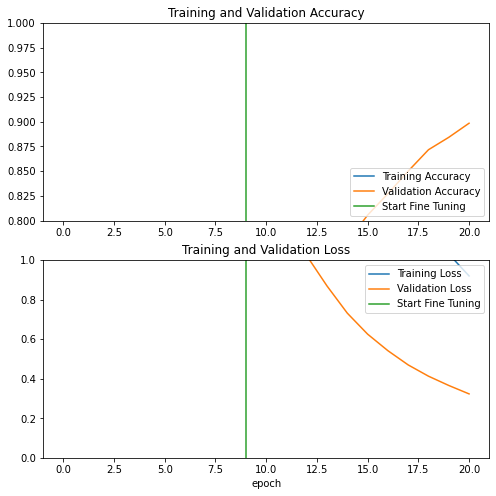

In [23]:
[history,history_finetune,tl_model,fineTuneModel] = trainTLModel(vgg_model,preprocess_input,100,train_ds,val_ds)

In [24]:
fineTuneModel.save('saved_models/vgg16model_finetune/', save_format='tf')

INFO:tensorflow:Assets written to: saved_models/vgg16model_finetune/assets


INFO:tensorflow:Assets written to: saved_models/vgg16model_finetune/assets


In [25]:
tl_model.save('saved_models/vgg16model_transferlearning/', save_format='tf')

INFO:tensorflow:Assets written to: saved_models/vgg16model_transferlearning/assets


INFO:tensorflow:Assets written to: saved_models/vgg16model_transferlearning/assets


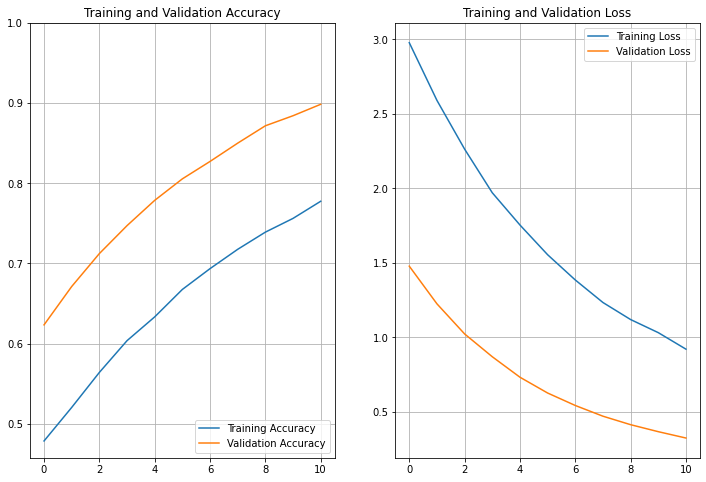

In [26]:
plot_history(history_finetune,"accuracy","val_accuracy")